# Analisi di sopravvivenza

L'Analisi di sopravvienza è un modo per descrivere quanto durano le cose. E' usato molto spesso per studiare l'aspettativa di vita, ma si applica anche all'analisi dei componenti meccaninici ed elettronici o più in generale in un intervallo di tempo prima di un evento.

Se a qualcuno che conosci è stata diagnosticata una malattia, avresti potuto sentir dire una percentuale di sopravvienza sui 5 anni, che rappresenta la probabilità di sopravvivere 5 anni dopo la diagnosi. La stima e le relative statistiche sono il risultato dell'analisi di sopravvivenza.

## Curve di sopravvivenza
Il concetto fondamenta di una analisi di sopravvivenza è la curva di sopravvivenza $S(t)$ che è una funzione che mappa la durata $t$ in una probabilità di sopravvivere più di t. Se conosciamo la distribuzione delle durate o "vite" trovare la curva di sopravvivenza è semplice è semplicemente il complemento del CDF 

$$S(t) = 1 − CDF(t)$$ 


dove $CDF(t)$ è la probabilità di vita minore o uguale a t.
Per esempio, nel dataset NSFG, sappiamo la durata di 11189 gravidanze. Possiamo leggere questi dati e calcolare il CDF:

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


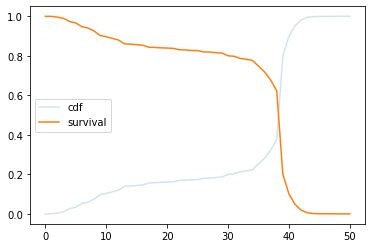

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from utils import readReadFemPreg,calcCdf

preg = readReadFemPreg()

complete = preg.query('outcome in [1, 3, 4]').prglngth
print('Number of complete pregnancies', len(complete))

values,pmf,cdf = calcCdf(complete)
ss = 1 - cdf

plt.plot(values,cdf,alpha=0.2,label="cdf")
plt.plot(values,ss,label="survival")
plt.legend(loc='center left')

ongoing = preg[preg.outcome == 6].prglngth
print('Number of ongoing pregnancies', len(ongoing))


## Funzione di rischio

Dalla curva di sopravvivenza possiamo derivare la funzione di rischio; per la lunghezza della gestazione la funzione di rischo mappa il tempo t il numero di gestazioni che continuano fino a t e che terminano a t. Per essere più precisi:

$$
\lambda = \frac{S_{(t)} - S_{(t-1)}}{S_{(t)}}
$$

Il numeratore è una frazione di aspettative di vita che terminano a t, che è anche la funzione PMF(t).

0.49689440993788797


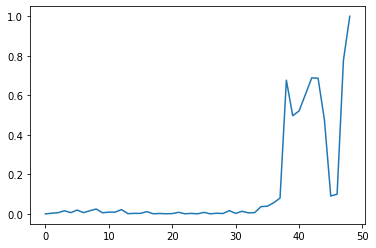

In [3]:
hazard = (ss[:-1] - ss[1:]) / ss[:-1]
plt.plot(values[:-1],hazard,label='hazard')

print(hazard[39])


Dunque tutte le gestazioni che precedono la settimana 39, circa il 50% precedono la settimana 39. 
Per i tempi dopo le 42 settimane la funzione di rischio e erratica perchè si basa su pochi casi. 
A parte questo la forma della curva è quella aspettata: è più alta attorno alle 39 settimane, e leggermente più alta nel primo trimestre che nel secondo.

La funzione di richio è utile di per se, ma è anche uno strumento importante per stimare le curve di sopravvivenza, le vedremo nella prossima sezione.

# Inferire le curve di sopravvivenza 
Se qualcuno ci da il CDF delle cite, è semplice calcolare le funzioni di sopravvivenza e rischio. Ma in molti scenari del mondo reale non possiamo misurare la distribuzione delle vite direttamente. Dobbiamo dedurla.

Per esempio, supponiamo che tu stia seguendo un gruppo di pazienti per vedere quanto sopravvivono dopo la diagnosi. Non tutti i pazienti sono diagnosticati lo stesso giorno, quindi in qualsiasi momento alcuni pazienti sono sopravvissuti più degli altri.
Se alcuni pazienti sono morti conosciamo il loro tempo di sopravvivenza. Per i pazienti che sono ancora vivi, non conosciamo il loro tempo di sopravvivenza, ma abbiamo il loro limite inferiore.

Se aspettiamo che tutti i pazienti siano morti, possiamo calcolare la funzione di sopravvivenza, ma se stiamo valutando l'efficacia di un nuovo trattamento non possiamo aspettare così a lungo!. Abbiamo bisgono di stimare la curva di sopravvivenza usando le informazioni non complete.

Come esempio più allegro, useremo i dati dell'NSFG per quantificare quanto tempo gli intervistati "sopravvivono" finchè non si sposano per la prima volta.

L'intervallo di età  degli intervistati varia dai 14 ai 44 anni,dunque il dataset ci fornisce una istantanea di differenti donne nelle loro fasi di vita.

Per le donne che si sono sposate, il dataset include le date del loro primo matrimonio e la loro età a quel tempo. Per le donne che non sono mai state sposarte, conosciamo la loro età quando intervistate, ma non abbiamo nessun sistema per conoscere quando o se siano sposate.

Dal momento che conosciamo l'età del primo matrimonio per alcune donne, potrebbe essere allettante escludere il resto dei dati e calcolare il CDF dei dati conosciuti. 

Questa non è una buona idea. Il risultato sarebbe doppiamente forviante:

1. Le donne anziane sono sovrarappresentate, perchè è molto probabile che siano sposate quando intervisate.
2. Le donne sposate sono sovrarappresentate, nei fatti questa analisi porterebbe al risultato che tutte le donne si sposano, il che ovviamente questo non è un risultato corretto.

## Lo stimatore Kaplan-Meier
In questo esempio non è solo desiderabile ma necessario includere le osservazioni delle donne non sposate, il che ci porta a uno degli algoritmi centrali nella analisi di sopravvivenza, lo stimatore Kaplan-Meier.

L'idea generale è che possiamo usare i dati per stimare la funzione di rischio, poi convertiamo la funzione di rischio nella curva di sopravvivenza. 
Per stimare la funzione di rischio, consideriamo per ogni età:

1. Il numero di donne che si sono sposate a quella età
2. Il numero di donne "a rischio" di sposarsi, che include tutte le donne che non erano sposate prima di quella età.

Qui il codice:

In [24]:
from collections import Counter
import pandas as pd

def MakeSurvival(series):
    ts = series.index
    ss = (1 - series).cumprod()
    
    return np.interp(ts, ts, ss, left=1.0)


def EstimateHazardFunction(complete, ongoing):

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts,dtype='float64')
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        at_risk -= ended + censored

    return lams,MakeSurvival(lams)

`complete` è l'insieme completo delle osservazioni, in questo caso, le età degli intervistati sposati. `ongoing` è l'insieme delle osservazioni incomplete; cioè l'età delle donne non sposate quando intervistate.

Prima, si precalcola `hist_complete` che è un oggetto Counter che mappa ogni età sul numero delle donne sposate a quella età e 
`hist_ongoing` che mappa per ogni età il numero di donne non sposate a quella età.
`ts` è l'unione delle età che degli intervistati sposate e non, ordinate in ordine crescente.

`at_risk` tiene traccia del numero degli intervistati considerati "a rischio" per ogni età; inizialmente è il numero totate delle intervistate.
Il risultato viene salvato in una serie Pandas che mappa ogni età con la funzione di rischio stimata per quella età.

Ogno volta che iteriamo nel loop consideriamo una età `t` calcoliamo il numero di eventi che finiscono a t (il numero di persone sposate all'età a quella età) e il numero di eventi censurati in t (che rapprenta il numero di donne intervistate in t il cui la data di matrimonio futuro è censurato). In questo contesto "censurato" significa che la data non è disponibile per il prcesso di raccolta.

La funzione di rischio è la frazione dei casi dei casi a rischio che finiscono in t.


## La curva dei matrimoni

Per testare questa funzione dobbiamo pulire i dati e trasformarli. Le variabili NSFG di cui abbiamo bisogno sono:

* cmbirth: la data di nascita di tutte le intervistate
* cmintvw: la data della intervista di tutte le intervistate
* cmmarrhx: la data del primo matrimonio della persona, se presente e sconosciuta.
* evrmarry: 1 se l'intervistato è stato sposato prima della data della intervista 0 altrimenti.

Le prima tre variabili sono codificate in "centinaia di mesi", che rappresenta il numero di mesi passati da dicembre 1899. Dunque il numero 1 rappresenta gennaio 1900.


Per prima cosa leggiamo il file delle persone intervistatee puliamo i valori di cmmarrhx:

In [25]:
from utils import readFemResp

resp = readFemResp()
resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

Poi calcoliamo l'età delle intervistate quando si sono sposate e quando sono state intervistate.

In [26]:
resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

Poi estraiamo `complete` che rappresenta l'insieme delle età delle donne che si sono sposate e `ongoing` che rappresenta l'età delle donne che non lo sono:

In [30]:
complete = resp[resp.evrmarry==1].agemarry.dropna()
ongoing = resp[resp.evrmarry==0].age

ed in fine calcoliamo la funzione di rischio.

In [31]:
hf = EstimateHazardFunction(complete, ongoing)

Text(0, 0.5, 'hazard')

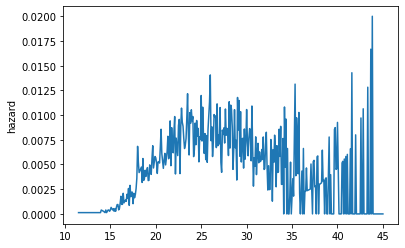

In [36]:
plt.plot(hf[0].index,hf[0].values)
plt.ylabel('hazard')

La figura mostra la stima della funzione di rischio, è bassa nella gioventù si alza verso i 20 e declina verso i 30 e ricresce verso i 40, ma questo è un artefatto del processo di stima, il numero degli intervistati "a rischio" decrementa, un piccolo numero di donne genera una stima del rischio grande. La curva della sopravvivenza smusserà questo rumore.